In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostRegressor

import numpy as np

In [29]:

# Load the dataset from the provided file
file_path = 'challenge_set.csv'

# Function to load and preprocess the data
def load(file_path):
    df = pd.read_csv(file_path)
    m, s = df['tow'].mean(), df['tow'].std()
    df['date'] = pd.to_datetime(df['date'])
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    df['offblock_hour'] = df['actual_offblock_time'].dt.round('h').dt.hour
    df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
    df['offblock_month'] = df['actual_offblock_time'].dt.month
    df = df.drop(columns=['flight_id', 'name_adep', 'callsign', 'actual_offblock_time', 'arrival_time', 'date'])
    df['tow'] = (df['tow'] - m) / s  # Standardize 'tow' column
    return df, m, s

# Load the data
df, mean, std = load(file_path)

# Display the first few rows of the dataframe to verify
df.head()


,adep,country_code_adep,ades,name_ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,offblock_hour,offblock_day_of_week,offblock_month
0,EGLL,GB,EICK,Cork,IE,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,-0.464485,14,5,1
1,LEBL,ES,KMIA,Miami,US,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,570,13,4193,1.989801,10,5,1
2,ESSA,SE,KORD,Chicago O'Hare,US,A333,H,8be5c854fd664bcb97fb543339f74770,554,15,3770,2.834012,10,5,1
3,LSZH,CH,KPHL,Philadelphia,US,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,497,11,3607,1.467256,11,5,1
4,EIDW,IE,EGLL,London Heathrow,GB,A21N,M,a73f82288988b79be490c6322f4c32ed,55,14,305,-0.172087,13,5,1


In [30]:
# Separate features and target variable
X = df.drop(columns=['tow'])
y = df['tow']

# Identify categorical columns
categorical_columns = ['adep', 'country_code_adep', 'ades', 'name_ades', 
                       'country_code_ades', 'aircraft_type', 'wtc', 'airline']



In [31]:
# Label encode the categorical columns instead of one-hot encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [32]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

# Initialize and train the AdaBoostRegressor
ada_regressor = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ada_regressor.predict(X)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
mse

0.03978943208987905

In [33]:
# Since we already have mean and std from the normalization, let's calculate RMSE for the denormalized values

# Define the root_mean_squared_error function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Denormalize both the actual and predicted values
y_test_denormalized = y * std + mean
y_pred_denormalized = y_pred * std + mean

# Compute the RMSE
rmse = root_mean_squared_error(y_test_denormalized, y_pred_denormalized)

# Print the RMSE
rmse


10622.114599738949

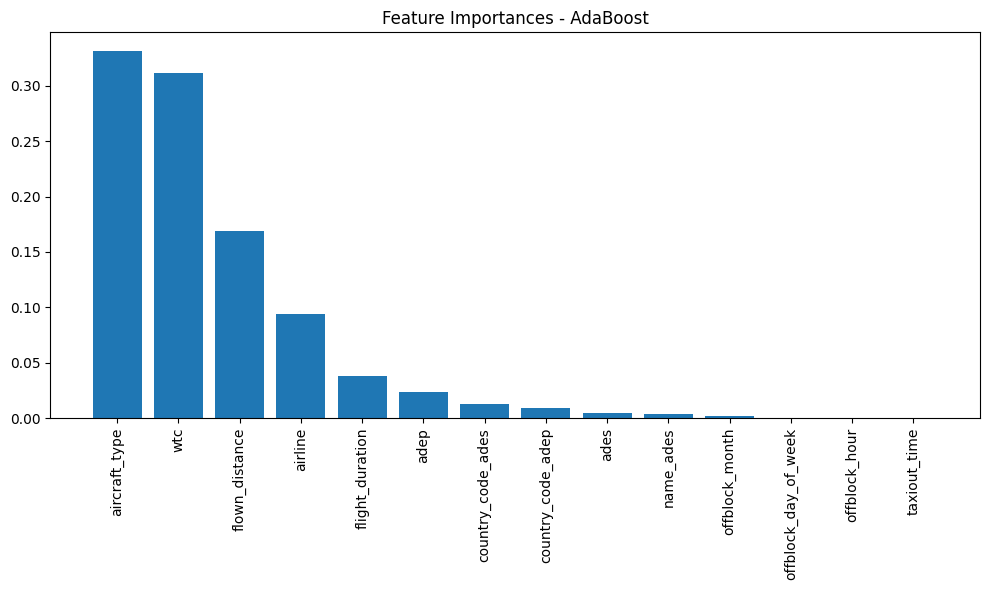

In [34]:
import matplotlib.pyplot as plt

# Extract feature importances for AdaBoost (based on feature importance from the decision trees)
importances = ada_regressor.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances for AdaBoost
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - AdaBoost")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## Hyperparameter Tunning


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Define the parameter grid for AdaBoost
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3, 4, 5],  # Depth of the decision trees
    'loss': ['linear', 'square', 'exponential']  # Loss function
}

# Initialize AdaBoostRegressor with a decision tree as the base estimator
base_estimator = DecisionTreeRegressor(random_state=42)
ada_regressor_tuned = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=ada_regressor_tuned,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(best_params)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END estimator__max_depth=1, learning_rate=0.5, loss=linear, n_estimators=50; total time=  20.1s
[CV] END estimator__max_depth=1, learning_rate=0.5, loss=linear, n_estimators=50; total time=  20.7s
[CV] END estimator__max_depth=1, learning_rate=0.5, loss=linear, n_estimators=50; total time=  21.1s
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=exponential, n_estimators=100; total time=  44.4s
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=exponential, n_estimators=100; total time=  44.8s
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=exponential, n_estimators=100; total time=  40.4s
[CV] END estimator__max_depth=3, learning_rate=0.01, loss=exponential, n_estimators=50; total time=  30.7s
[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=200; total time= 1.3min
[CV] END estimator__max_depth=1, learning_rate=0.01, loss=square, n_estimators=200; total time= 1.3min
[C

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.01, loss=exponential, n_estimators=100; total time=  39.0s
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=200; total time=  45.2s
[CV] END estimator__max_depth=5, learning_rate=1.0, loss=square, n_estimators=100; total time= 1.0min
[CV] END estimator__max_depth=1, learning_rate=0.01, loss=exponential, n_estimators=100; total time=  32.0s
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=200; total time= 1.2min
[CV] END estimator__max_depth=2, learning_rate=1.0, loss=linear, n_estimators=200; total time= 1.2min
[CV] END estimator__max_depth=3, learning_rate=1.0, loss=exponential, n_estimators=300; total time= 1.4min
[CV] END estimator__max_depth=3, learning_rate=1.0, loss=exponential, n_estimators=300; total time= 1.4min
[CV] END estimator__max_depth=3, learning_rate=1.0, loss=exponential, n_estimators=300; total time= 1.3min
{'n_estimators': 100, 'loss': 'square', 'learning_rate'

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'mean' and 'std' were used to normalize the 'tow' column
# and preds_val contains the model predictions on the validation set.

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Denormalize both the actual and predicted values (y_val and preds_val)
y_val_denormalized = y * std + mean
preds_val_denormalized = y_pred * std + mean

# Compute the RMSE
rmse = root_mean_squared_error(y_val_denormalized, preds_val_denormalized)

# Print the RMSE
print('Model validation RMSE: {:.4f}'.format(rmse))


Model validation RMSE: 10622.1146


## SUBMISION

In [38]:
import numpy as np

# Function to extend the label encoder with new unseen labels (convert all to string to avoid dtype mismatch)
def extend_label_encoder(encoder, new_labels):
    """Extend the LabelEncoder to handle new labels in the test set."""
    current_classes = list(encoder.classes_.astype(str))  # Ensure all current classes are strings
    for label in new_labels:
        label = str(label)  # Convert new labels to strings
        if label not in current_classes:
            current_classes.append(label)
    encoder.classes_ = np.array(sorted(current_classes))  # Keep classes sorted

# Loop through the categorical columns and extend the label encoders with unseen labels
for col in categorical_columns:
    if col in label_encoders:
        unseen_labels = set(X[col].astype(str).unique()) - set(label_encoders[col].classes_.astype(str))
        if unseen_labels:
            extend_label_encoder(label_encoders[col], unseen_labels)
        X[col] = label_encoders[col].transform(X[col].astype(str))

# Predict on the encoded test set using the trained AdaBoost model
y_pred = ada_regressor.predict(X)

# Denormalize the predictions
y_test_denormalized = y_pred * std + mean

# Print the denormalized predictions
print("Denormalized Predictions (y_test):")
print(y_test_denormalized)


Denormalized Predictions (y_test):
[ 52738.61714438 200835.25442398 189745.77542739 ...  52738.61714438
  61530.29950264 196207.34720925]


In [39]:
import pandas as pd

# Assuming 'y_test_denormalized' contains the predictions and 'submission_set.csv' has the 'flight_id' column

# Load the test data to extract 'flight_id'
dft0 = pd.read_csv('submission_set.csv')

# Ensure both arrays have the same length by trimming y_test_denormalized to match dft0
min_length = min(len(dft0), len(y_test_denormalized))
y_test_denormalized = y_test_denormalized[:min_length]

# Assign the denormalized predictions to the 'tow' column
dft0['tow'] = y_test_denormalized

# Save the flight_id and tow columns to a CSV file
dft0[['flight_id', 'tow']].to_csv('adaboots.csv', index=False)

# Print a confirmation message
print("Predictions saved to 'adaboots.csv'.")

Predictions saved to 'adaboots.csv'.


In [40]:
!head adaboots.csv

flight_id,tow
248753821,52738.61714437893
248753822,200835.25442398235
248754498,189745.7754273892
248757623,191177.32000438182
248763603,61530.29950263833
248755068,73059.46233147997
248754229,49802.111098065376
248754894,61530.29950263833
248754751,194364.5163117756
